In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [2]:
# Cargar los datos desde un archivo CSV
df = pd.read_excel('ProyectoMBD_MST_ML.xlsx')
df.describe()

,No_Semana,Mes,Año,Fecha Siembra,Fecha Muestreo,Numero_Semanas_Cultivo,Epoca,Peso Semanal,Incremento semanal,TAN,...,Magnesio,Potasio,Nitrito,Fosfato,Amonio,Silicio,Oxigeno,Temperatura,PH,Salinidad
count,998.000000,998.000000,998.0,998,998,998.000000,998.000000,998.000000,998.000000,998.000000,...,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000
mean,23.045090,5.623246,2024.0,2024-04-29 07:18:38.236472832,2024-06-09 07:34:30.541082112,6.308617,0.473948,17.454038,3.021042,0.278233,...,177.261022,45.978457,0.075149,0.663607,0.255718,4.872355,3.662301,27.686573,8.210124,3.732331
min,1.000000,1.000000,2024.0,2023-12-24 00:00:00,2024-01-07 00:00:00,1.000000,0.000000,0.210000,0.100000,0.007000,...,10.000000,16.000000,0.002640,0.060000,0.006114,0.000000,2.442857,25.100000,7.655000,1.000000
25%,14.000000,4.000000,2024.0,2024-03-04 00:00:00,2024-04-07 00:00:00,3.000000,0.000000,6.000000,2.000000,0.120000,...,100.000000,30.000000,0.019800,0.370000,0.101236,2.500000,3.242857,26.500000,8.030000,2.000000
50%,24.000000,6.000000,2024.0,2024-05-10 00:00:00,2024-06-16 00:00:00,6.000000,0.000000,13.900000,3.000000,0.170000,...,150.000000,37.000000,0.042900,0.550000,0.160410,4.000000,3.614286,27.000000,8.165000,2.600000
75%,32.000000,8.000000,2024.0,2024-06-16 00:00:00,2024-08-11 00:00:00,9.000000,1.000000,25.750000,4.000000,0.380000,...,228.750000,59.000000,0.089100,0.800000,0.350028,6.200000,4.042857,29.600000,8.340000,5.500000
max,42.000000,10.000000,2024.0,2024-09-15 00:00:00,2024-10-20 00:00:00,19.000000,1.000000,60.200000,8.400000,1.540000,...,550.000000,190.000000,0.607200,3.950000,1.475453,33.700000,5.400000,31.500000,9.140000,13.700000
std,10.121676,2.321316,0.0,NaN,NaN,4.004629,0.499571,14.278817,1.402719,0.247443,...,106.701085,24.363879,0.087271,0.490750,0.236661,3.735982,0.540359,1.715561,0.251181,2.636804


In [3]:
df['Oxigeno_Temperatura'] = df['Oxigeno']*df['Temperatura']

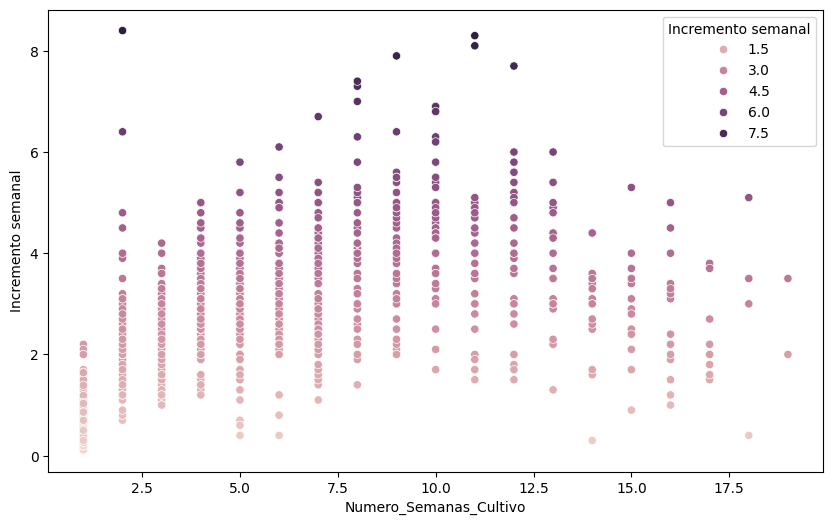

In [4]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df['Incremento semanal'], x=df['Numero_Semanas_Cultivo'], hue=df['Incremento semanal'])
plt.show()

In [5]:
# Definir una función para identificar outliers usando IQR
def imputar_outliers_con_mediana(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites para identificar outliers
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    # Calcular la mediana de la columna
    mediana = df[column].median()

    # Reemplazar los valores outliers con la mediana
    df[column] = np.where((df[column] < lower_limit) | (df[column] > upper_limit), 
                          mediana, 
                          df[column])
    return df


columns_to_clean = ['Peso Semanal', 'Incremento semanal', 'TAN', 'Sulfuro de hidrogeno', 'Amoniaco',
                    'Alcalinidad', 'Calcio', 'Magnesio', 'Potasio', 'Nitrito', 'Fosfato', 'Amonio',
                    'Silicio', 'Oxigeno', 'Temperatura', 'PH', 'Salinidad']
df = imputar_outliers_con_mediana(df, columns_to_clean)

# Verificar resultados
print(df.describe())

        No_Semana         Mes     Año                  Fecha Siembra  \
count  998.000000  998.000000   998.0                            998   
mean    23.045090    5.623246  2024.0  2024-04-29 07:18:38.236472832   
min      1.000000    1.000000  2024.0            2023-12-24 00:00:00   
25%     14.000000    4.000000  2024.0            2024-03-04 00:00:00   
50%     24.000000    6.000000  2024.0            2024-05-10 00:00:00   
75%     32.000000    8.000000  2024.0            2024-06-16 00:00:00   
max     42.000000   10.000000  2024.0            2024-09-15 00:00:00   
std     10.121676    2.321316     0.0                            NaN   

                      Fecha Muestreo  Numero_Semanas_Cultivo       Epoca  \
count                            998              998.000000  998.000000   
mean   2024-06-09 07:34:30.541082112                6.308617    0.473948   
min              2024-01-07 00:00:00                1.000000    0.000000   
25%              2024-04-07 00:00:00           

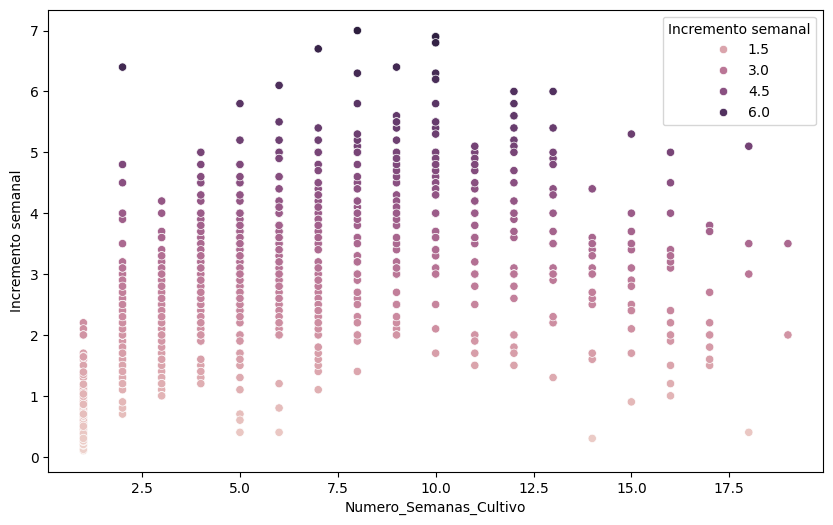

In [6]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df['Incremento semanal'], x=df['Numero_Semanas_Cultivo'], hue=df['Incremento semanal'])
plt.show()

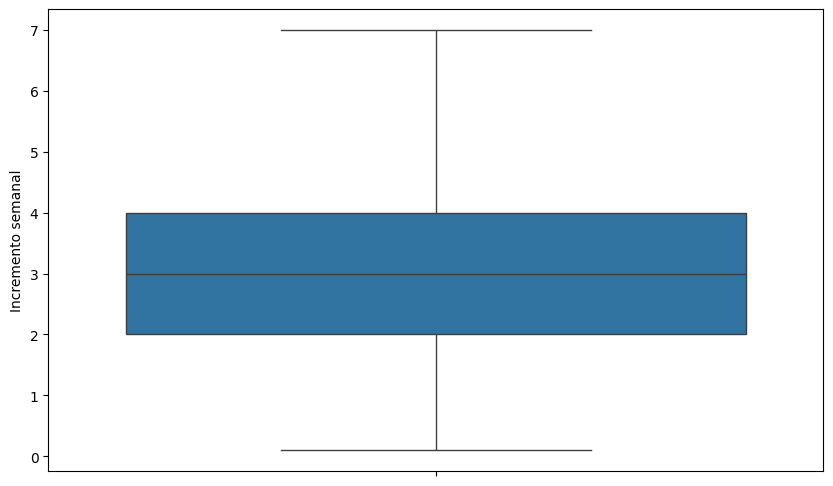

In [7]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df['Incremento semanal'])
plt.show()

In [8]:
df.describe()

,No_Semana,Mes,Año,Fecha Siembra,Fecha Muestreo,Numero_Semanas_Cultivo,Epoca,Peso Semanal,Incremento semanal,TAN,...,Potasio,Nitrito,Fosfato,Amonio,Silicio,Oxigeno,Temperatura,PH,Salinidad,Oxigeno_Temperatura
count,998.000000,998.000000,998.0,998,998,998.000000,998.000000,998.000000,998.000000,998.000000,...,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000
mean,23.045090,5.623246,2024.0,2024-04-29 07:18:38.236472832,2024-06-09 07:34:30.541082112,6.308617,0.473948,16.889208,2.986874,0.229125,...,42.360220,0.047218,0.573136,0.208914,4.223858,3.660512,27.686573,8.190437,3.392552,101.061629
min,1.000000,1.000000,2024.0,2023-12-24 00:00:00,2024-01-07 00:00:00,1.000000,0.000000,0.210000,0.100000,0.007000,...,16.000000,0.002640,0.060000,0.006114,0.000000,2.442857,25.100000,7.655000,1.000000,74.018571
25%,14.000000,4.000000,2024.0,2024-03-04 00:00:00,2024-04-07 00:00:00,3.000000,0.000000,6.000000,2.000000,0.120000,...,30.000000,0.019800,0.370000,0.101236,2.500000,3.242857,26.500000,8.030000,2.000000,90.228214
50%,24.000000,6.000000,2024.0,2024-05-10 00:00:00,2024-06-16 00:00:00,6.000000,0.000000,13.900000,3.000000,0.170000,...,37.000000,0.042900,0.550000,0.160410,4.000000,3.614286,27.000000,8.165000,2.600000,99.085714
75%,32.000000,8.000000,2024.0,2024-06-16 00:00:00,2024-08-11 00:00:00,9.000000,1.000000,24.875000,4.000000,0.290000,...,52.000000,0.052800,0.707500,0.261924,5.500000,4.042857,29.600000,8.315000,4.300000,110.202143
max,42.000000,10.000000,2024.0,2024-09-15 00:00:00,2024-10-20 00:00:00,19.000000,1.000000,55.300000,7.000000,0.770000,...,100.000000,0.191400,1.430000,0.711000,11.700000,5.200000,31.500000,8.800000,10.700000,151.790000
std,10.121676,2.321316,0.0,NaN,NaN,4.004629,0.499571,13.528968,1.341708,0.165560,...,18.518113,0.037996,0.287956,0.156372,2.506877,0.537548,1.715561,0.220716,2.112668,14.090015


In [9]:
df['Fecha Siembra'] = pd.to_datetime(df['Fecha Siembra'])
df['Fecha Muestreo'] = pd.to_datetime(df['Fecha Muestreo'])
df['Numero_Semanas_Cultivo'] = ((df['Fecha Muestreo'] - df['Fecha Siembra']).dt.days / 7).astype(int)
df.head(20)


,Piscina_Ciclo,No_Semana,Mes,Año,Fecha Siembra,Fecha Muestreo,Numero_Semanas_Cultivo,Epoca,Peso Semanal,Incremento semanal,...,Potasio,Nitrito,Fosfato,Amonio,Silicio,Oxigeno,Temperatura,PH,Salinidad,Oxigeno_Temperatura
0,PS07-8,1,1,2024,2023-12-24,2024-01-07,2,1,3.0,2.0,...,100.0,0.02640,0.140,0.055418,11.40,4.085714,27.0,8.580000,2.600000,110.314286
1,PS08-9,1,1,2024,2023-12-24,2024-01-07,2,1,3.1,2.1,...,64.5,0.01815,0.720,0.071649,4.00,3.985714,27.0,8.650000,7.000000,107.614286
2,PS10-6,1,1,2024,2023-12-24,2024-01-07,2,1,3.1,2.0,...,37.0,0.06270,0.680,0.085769,4.00,4.042857,27.0,8.370000,2.600000,109.157143
3,PS07-8,2,1,2024,2023-12-24,2024-01-14,3,1,4.5,1.5,...,75.0,0.04950,0.800,0.066751,4.00,4.157143,27.0,8.710000,10.000000,112.242857
4,PS08-9,2,1,2024,2023-12-24,2024-01-14,3,1,4.6,1.5,...,88.0,0.00330,0.400,0.068180,4.00,3.828571,27.0,8.670000,10.000000,103.371429
5,PS10-6,2,1,2024,2023-12-24,2024-01-14,3,1,4.7,1.6,...,77.0,0.00660,0.800,0.073477,4.00,3.814286,27.0,8.520000,10.000000,102.985714
6,PS07-8,3,1,2024,2023-12-24,2024-01-21,4,1,6.6,2.1,...,41.0,0.04290,0.735,0.612482,7.90,4.128571,27.0,8.083333,3.666667,111.471429
7,PS08-9,3,1,2024,2023-12-24,2024-01-21,4,1,6.6,2.0,...,39.0,0.04290,0.420,0.566079,10.05,3.928571,27.0,8.192500,2.750000,106.071429
8,PS10-6,3,1,2024,2023-12-24,2024-01-21,4,1,7.0,2.3,...,38.0,0.04290,0.610,0.707188,8.20,4.028571,27.0,8.106667,4.000000,108.771429
9,PS07-8,4,1,2024,2023-12-24,2024-01-28,5,1,10.1,3.5,...,73.0,0.01815,0.730,0.091251,6.90,4.057143,27.0,8.635000,6.500000,109.542857


In [10]:
# Definir variables predictoras y objetivo
X = df[[ 'Oxigeno','Temperatura','Salinidad', 'Numero_Semanas_Cultivo',
             'Sulfuro de hidrogeno', 'Alcalinidad', 'Nitrito', 'Amonio', 'PH']]
y = df['Incremento semanal']  # Variable objetivo

# Estandarización antes de la división
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")


Mejores parámetros: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [12]:
# Suponiendo que la columna objetivo se llama 'variable_objetivo'
media_objetivo = df['Incremento semanal'].mean()
desviacion_objetivo = df['Incremento semanal'].std()

print(f"Media de la variable objetivo: {media_objetivo}")
print(f"Desviación estándar de la variable objetivo: {desviacion_objetivo}")

Media de la variable objetivo: 2.9868737474949896
Desviación estándar de la variable objetivo: 1.3417077121514671


In [13]:
#'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300
#{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
#   
# Entrenar el modelo de bosque aleatorio
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, oob_score=True,  random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=200,
                      oob_score=True, random_state=42)

In [14]:
# Evaluar el modelo
y_pred_rf = rf_model.predict(X_test)
y_pred__train_rf = rf_model.predict(X_train)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_squared_error(y_test, y_pred_rf)
r2_train_rf = r2_score(y_train, y_pred__train_rf)


print(f'MSE: {mse_rf}')
print(f'MAE: {mae_rf}')
print(f'R2 Score: {r2_rf}')
print(f'R2 Score train: {r2_train_rf}')
print(f'oob Score: {rf_model.oob_score_}')

MSE: 0.7685613577296913
MAE: 0.7685613577296913
R2 Score: 0.47393398513605267
R2 Score train: 0.8135643498436147
oob Score: 0.5129927808000558


In [15]:
from sklearn.model_selection import cross_val_score
# Aplicar validación cruzada
scores = cross_val_score(rf_model, X_scaled, y, cv=5, scoring='r2')  # cv=5 es para 5-fold cross-validation
print("Cross-validation R2 scores:", scores)
print("Mean R2 score:", scores.mean())

Cross-validation R2 scores: [0.35703388 0.37175859 0.47196081 0.42096713 0.21322169]
Mean R2 score: 0.3669884203382564


C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


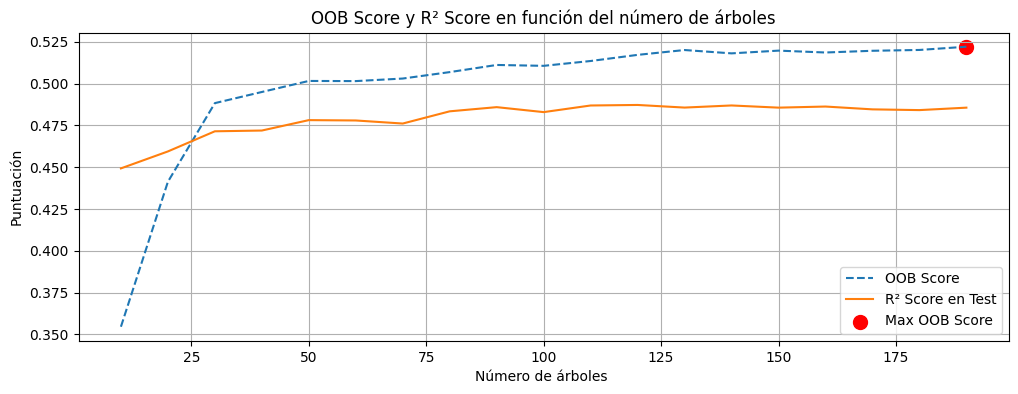

Valor optimo de n_estimators:  190


In [16]:
 #Listas para almacenar los valores de OOB y R2
oob_scores = []
r2_scores = []

# Valores de n_estimators a probar
n_estimators_range = range(10, 200, 10)

# Entrenamiento del modelo para diferentes números de árboles
for n_estimators in n_estimators_range:
    rf = RandomForestRegressor(n_estimators=n_estimators, oob_score=True, random_state=42)
    rf.fit(X_train, y_train)
    
    # Guardar el OOB Score
    oob_scores.append(rf.oob_score_)
    
    # Predecir en el conjunto de prueba y calcular R2
    y_pred = rf.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
# Find the maximum OOB score and its corresponding n_estimators
max_oob_score = max(oob_scores)
max_oob_index = oob_scores.index(max_oob_score)
best_n_estimators = n_estimators_range[max_oob_index]

# Graficar los resultados
plt.figure(figsize=(12, 4))
plt.plot(n_estimators_range, oob_scores, label='OOB Score', linestyle='--')
plt.plot(n_estimators_range, r2_scores, label='R² Score en Test', linestyle='-')
# Mark the maximum OOB score point
plt.scatter(best_n_estimators, max_oob_score, color='red', s=100, label='Max OOB Score')
plt.xlabel("Número de árboles ")
plt.ylabel("Puntuación")
plt.title("OOB Score y R² Score en función del número de árboles")
plt.legend()
plt.grid()
plt.show()
print("Valor optimo de n_estimators: ",best_n_estimators)

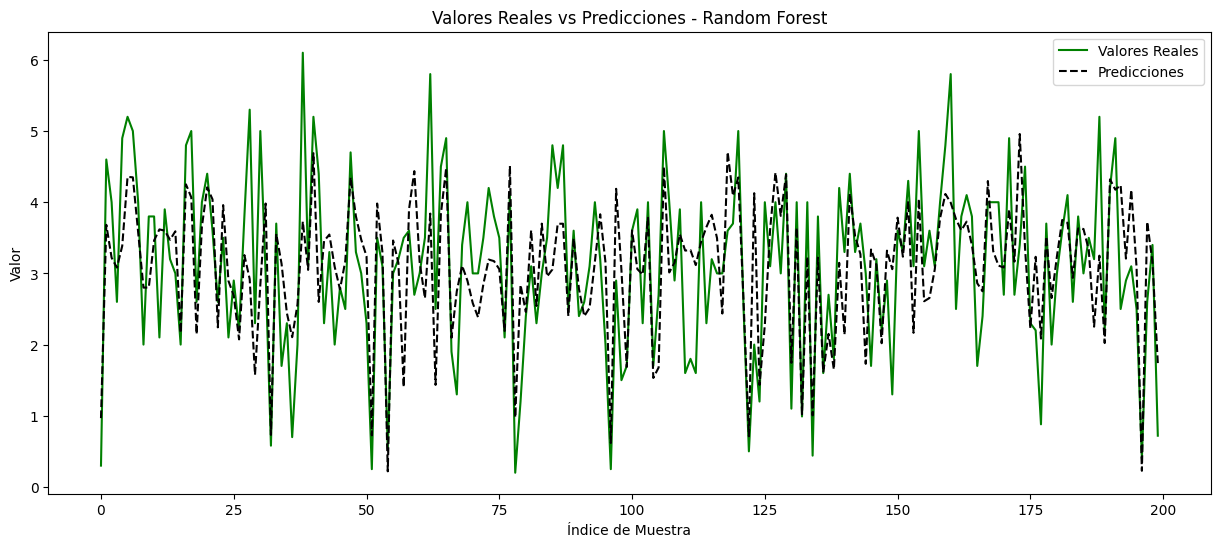

In [17]:
# Gráfico de línea para los valores reales vs predicciones
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Valores Reales', color='green')
plt.plot(y_pred, label='Predicciones', color='black', linestyle="--")
plt.xlabel('Índice de Muestra')
plt.ylabel('Valor')
plt.title('Valores Reales vs Predicciones - Random Forest')
plt.legend()
plt.show()

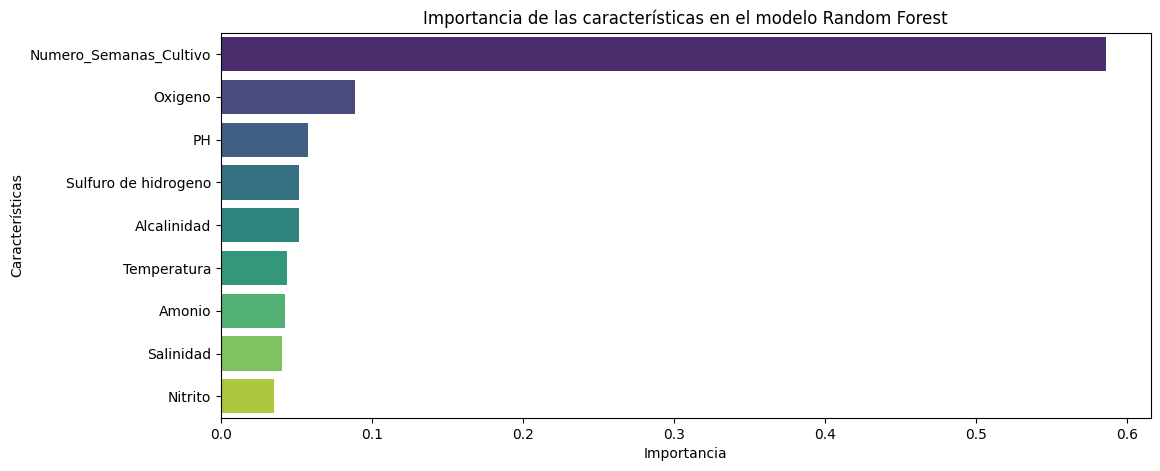

In [18]:

importances = rf_model.feature_importances_
feature_names = X.columns

# Crear un DataFrame con las importancias
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Mostrar gráfico de barras de importancias
plt.figure(figsize=(12, 5))
sns.barplot(x='Importance', y='Feature',hue='Feature', data=importances_df, palette='viridis')

# Etiquetas y título
plt.title('Importancia de las características en el modelo Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Características')

# Mostrar el gráfico
plt.show()



Coeficientes estandarizados:
{'Oxigeno': -0.4187586937501959, 'Temperatura': -0.0017616188336224275, 'Salinidad': -0.05300670924655236, 'Numero_Semanas_Cultivo': 0.5557009092316237, 'Sulfuro de hidrogeno': -0.06249243162582752, 'Alcalinidad': 0.1695183167470132, 'Nitrito': -0.010359012861802838, 'Amonio': 0.0591280232076659, 'PH': 0.1363140831200073}
Regresión Lineal - Error cuadrático medio (MSE): 1.1454592680157918
Regresión Lineal - (RMSE): 1.0702613082868089
Regresión Lineal - Error absoluto medio (MAE): 0.8420180668362499
Regresión Lineal - Coeficiente de determinación (R²): 0.21595434606019293


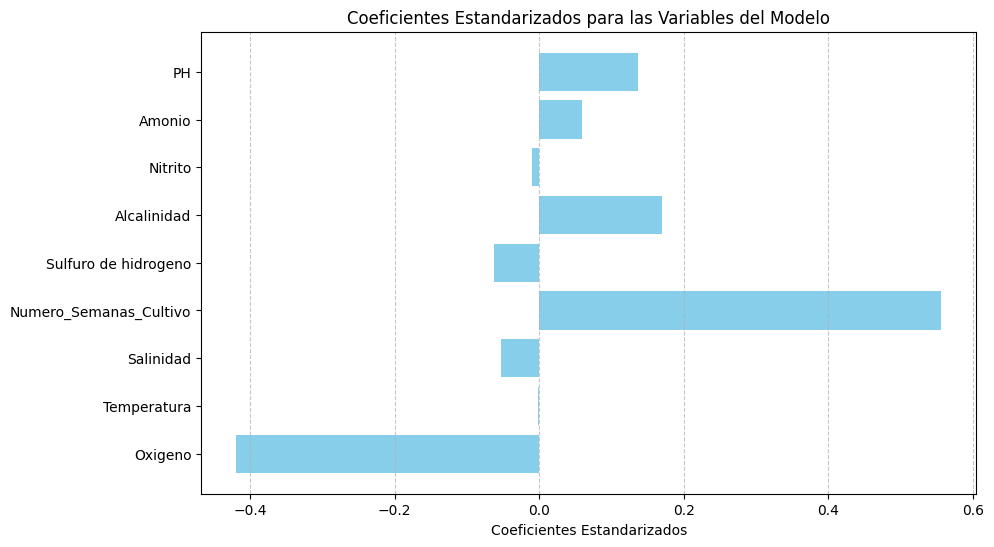

In [19]:
# Entrenar el modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predicciones
y_pred_linear = linear_model.predict(X_test)

# Evaluar el modelo
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Obtener los coeficientes estandarizados
coef_estandarizados = linear_model.coef_

# Mostrar los coeficientes estandarizados
coef_dict = {X.columns[i]: coef_estandarizados[i] for i in range(len(X.columns))}
print("Coeficientes estandarizados:")
print(coef_dict)


print("Regresión Lineal - Error cuadrático medio (MSE):", mse_linear)
print("Regresión Lineal - (RMSE):", rmse_linear)
print("Regresión Lineal - Error absoluto medio (MAE):", mae_linear)
print("Regresión Lineal - Coeficiente de determinación (R²):", r2_linear)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.barh(list(coef_dict.keys()), list(coef_dict.values()), color='skyblue')
plt.xlabel('Coeficientes Estandarizados')
plt.title('Coeficientes Estandarizados para las Variables del Modelo')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

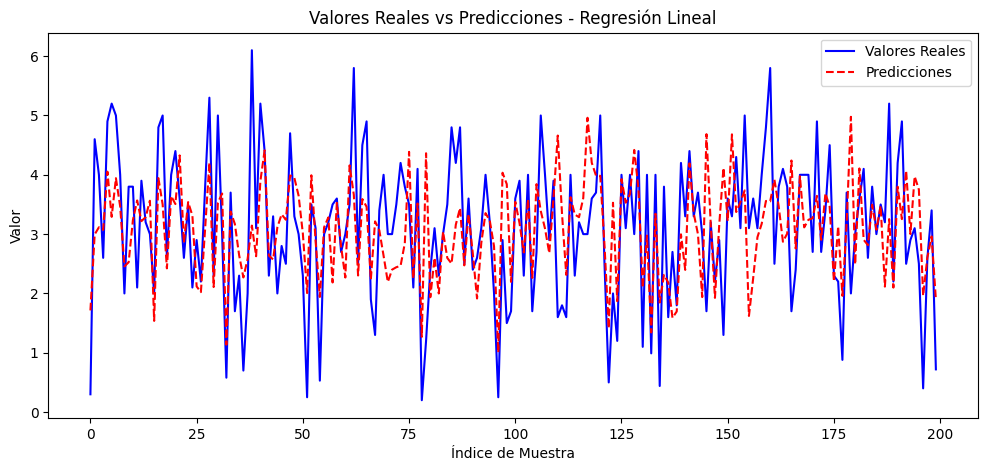

In [20]:
# Gráfico de línea para los valores reales vs predicciones
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Valores Reales', color='blue')
plt.plot(y_pred_linear, label='Predicciones', color='red', linestyle='--')
plt.xlabel('Índice de Muestra')
plt.ylabel('Valor')
plt.title('Valores Reales vs Predicciones - Regresión Lineal')
plt.legend()
plt.show()

In [21]:
pip install keras-tuner


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
# Definir el modelo Redes Neuronales RNN
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Configurar early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
print("Comenzando entrenamiento...")
# Entrenar el modelo
history = model.fit(X_train, y_train, validation_split=0.2, epochs=1000,  batch_size=32, verbose=False, callbacks=[early_stopping])
print("Modelo entrenado")

Comenzando entrenamiento...
Modelo entrenado


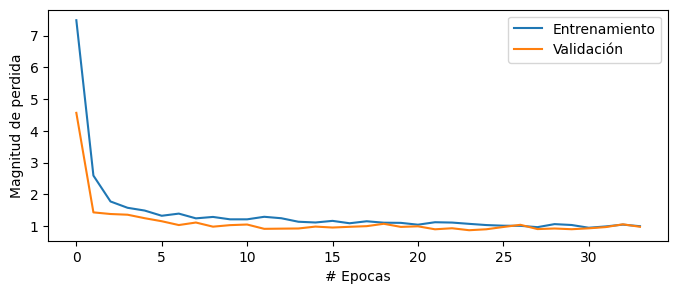

In [24]:
plt.figure(figsize=(8,3))
plt.xlabel("# Epocas")
plt.ylabel("Magnitud de perdida")
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.legend()
plt.show()

In [25]:
# Realizar predicciones
y_pred_nn = model.predict(X_test)

# Calcular métricas
mse_rnn = mean_squared_error(y_test, y_pred_nn)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
mae_rnn = mean_absolute_error(y_test, y_pred_nn)
r2_rnn = r2_score(y_test, y_pred_nn)

print(f"Red Neuronal - Error cuadrático medio (MSE): {mse_rnn}")
print(f"Red Neuronal - Error absoluto medio (MAE): {mae_rnn}")
print(f"Red Neuronal - Coeficiente de determinación (R²): {r2_rnn}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Red Neuronal - Error cuadrático medio (MSE): 0.8733347362531595
Red Neuronal - Error absoluto medio (MAE): 0.7370143009901047
Red Neuronal - Coeficiente de determinación (R²): 0.40221854804136326


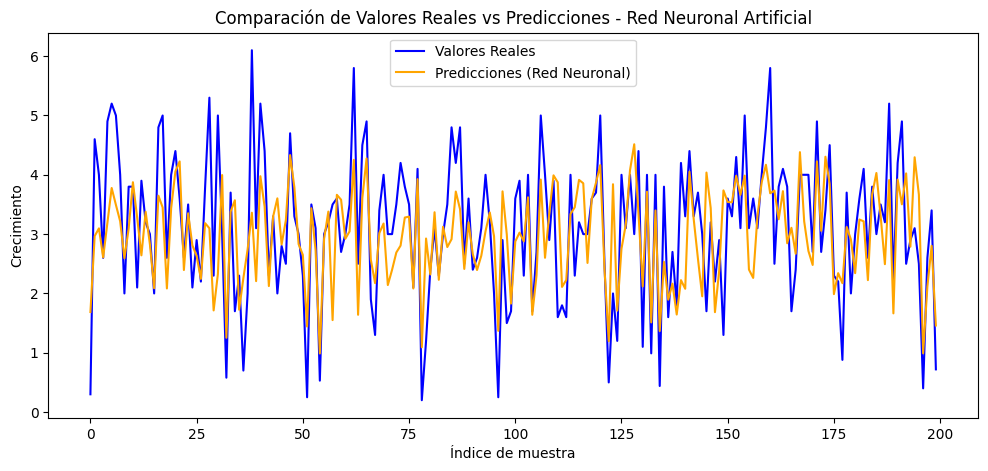

In [26]:
# Ordenar los índices para una comparación ordenada
y_test_sorted = y_test.reset_index(drop=True)  # Reiniciar índices para evitar errores
y_pred_nn_sorted = y_pred_nn.flatten()  # Asegurarse de que las predicciones estén en un arreglo 1D

# Crear la gráfica lineal
plt.figure(figsize=(12, 5))
plt.plot(y_test_sorted, label='Valores Reales', color='blue')
plt.plot(y_pred_nn_sorted, label='Predicciones (Red Neuronal)', color='orange')
plt.xlabel('Índice de muestra')
plt.ylabel('Crecimiento')
plt.title('Comparación de Valores Reales vs Predicciones - Red Neuronal Artificial')
plt.legend()
plt.show()

In [27]:
# Crear un modelo XGBoost

#Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
xg_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Entrenar el modelo
xg_model.fit(X_train, y_train)

# Predicciones
y_pred_xg = xg_model.predict(X_test)

# Evaluación del modelo
mse_xg = mean_squared_error(y_test, y_pred_xg)
mae_xg = mean_absolute_error(y_test, y_pred_xg)
rmse_xg = mse_xg ** 0.5
r2_xg = r2_score(y_test, y_pred_xg)

# Mostrar el valor de R²
print(f'Error cuadrático medio (RMSE): {rmse_xg}')
print(f'Coeficiente de determinación (R²): {r2_xg}')


Error cuadrático medio (RMSE): 0.9161097662105366
Coeficiente de determinación (R²): 0.42554405634147496


In [28]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xg_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")

Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


In [29]:
# Definir el modelo con los mejores parámetros
optimized_xg_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=100,
    subsample=0.8,
    random_state=42
)

# Entrenar el modelo
optimized_xg_model.fit(X_train, y_train)

# Predicciones
y_pred_optimized = optimized_xg_model.predict(X_test)

# Evaluación del modelo
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
rmse_optimized = mse_optimized ** 0.5
r2_optimized = r2_score(y_test, y_pred_optimized)

# Resultados
print(f"RMSE: {rmse_optimized}")
print(f"R²: {r2_optimized}")

RMSE: 0.8690619775599149
R²: 0.4830325488942746


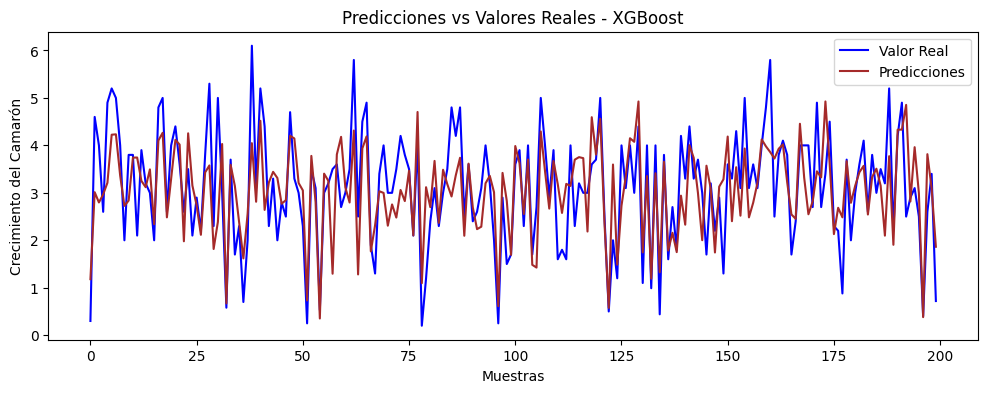

In [30]:
# Graficar predicciones vs valores reales
plt.figure(figsize=(12, 4))

# Trazar los valores reales
plt.plot(y_test.values, label='Valor Real', color='blue')

# Trazar las predicciones
plt.plot(y_pred_optimized, label='Predicciones', color='brown')

# Añadir títulos y etiquetas
plt.title('Predicciones vs Valores Reales - XGBoost')
plt.xlabel('Muestras')
plt.ylabel('Crecimiento del Camarón')
plt.legend()

# Mostrar gráfico
plt.show()

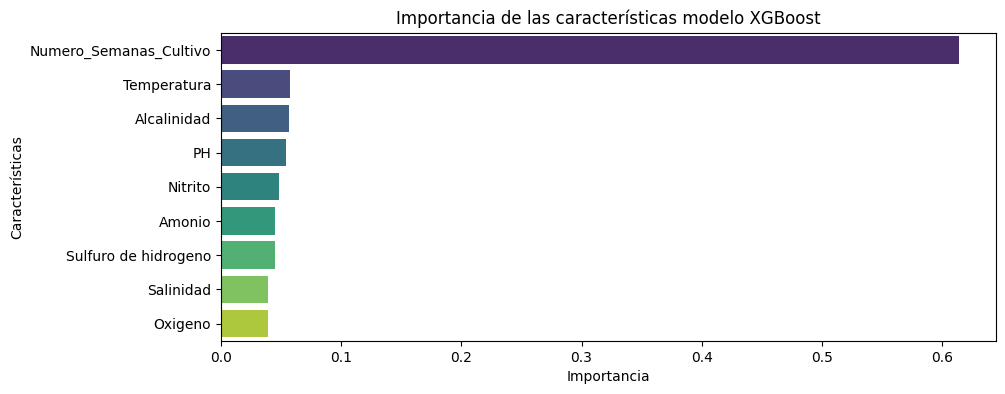

In [31]:
# Obtener la importancia de las características
importances = xg_model.feature_importances_
feature_names = X.columns

# Crear un DataFrame con las importancias
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Mostrar gráfico de barras de importancias
plt.figure(figsize=(10, 4))
sns.barplot(x='Importance', y='Feature', data=importances_df,hue='Feature', palette='viridis')

# Etiquetas y título
plt.title('Importancia de las características modelo XGBoost')
plt.xlabel('Importancia')
plt.ylabel('Características')

# Mostrar el gráfico
plt.show()

In [32]:
# Evaluar todos los modelos usando las métricas MAE, MSE, RMSE y R²
results = [
    ['Regresion Lienal Multiple', mse_linear, rmse_linear, mae_linear, r2_linear],
    ['Random Forest', mse_rf, rmse_rf, mae_rf, r2_rf],
    ['XGBoost', mse_xg, rmse_xg, mae_xg, r2_xg],
    ['RNN', mse_rnn, rmse_rnn,mae_rnn, r2_rnn]
]

# Crear un DataFrame para almacenar los resultados
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'RMSE', 'MAE', 'R²'])

# Mostrar los resultados
print(results_df)

                       Model       MSE      RMSE       MAE        R²
0  Regresion Lienal Multiple  1.145459  1.070261  0.842018  0.215954
1              Random Forest  0.768561  0.876676  0.768561  0.473934
2                    XGBoost  0.839257  0.916110  0.724891  0.425544
3                        RNN  0.873335  0.934524  0.737014  0.402219


In [33]:
def prediccion_peso(listPiscinas, df_nuevo_real, modelo, tipo_modelo):
    
    for piscina in listPiscinas:
        df_filtrado = df[df["Piscina_Ciclo"] == piscina]
        df_nuevo_filtrado = df_nuevo_real[df_nuevo_real["Piscina_Ciclo"] == piscina]
        # Definir variables predictoras y objetivo
        X_real = df_nuevo_filtrado[[ 'Oxigeno','Temperatura','Salinidad', 'Numero_Semanas_Cultivo',
                    'Sulfuro de hidrogeno', 'Alcalinidad', 'Nitrito', 'Amonio', 'PH']]
        X_real_scaled = scaler.fit_transform(X_real)
        # Hacer predicciones para las próximas dos semanas (puedes ajustar los valores según el patrón de crecimiento)

        # Predicciones para las próximas dos semanas
        future_predictions = model.predict(X_real_scaled)
        predicciones_rf = rf_model.predict(X_real_scaled)
        predicciones_lineal = linear_model.predict(X_real_scaled)
        predicciones_xg = optimized_xg_model.predict(X_real_scaled)

        # Comparar predicciones con datos reales (suponiendo que los tienes en df)
        df_real = df_nuevo_filtrado[[ 'Numero_Semanas_Cultivo','Incremento semanal']]
        # Añadir las predicciones al DataFrame para compararlas
        df_real["Prediccion_rn"] = future_predictions
        df_real["Prediccion_rf"] = predicciones_rf
        df_real["Prediccion_lineal"] = predicciones_lineal
        df_real["Prediccion_xg"] = predicciones_xg
        
        df_combinado = pd.concat([df_filtrado, df_real], ignore_index=True)
        # Visualizar los resultados
        plt.figure(figsize=(10, 6))
        plt.plot(df_combinado["Numero_Semanas_Cultivo"], df_combinado["Incremento semanal"], marker='o', color='b', label="Datos reales")
        plt.plot(df_real["Numero_Semanas_Cultivo"], df_real["Prediccion_rf"], marker='x', color='green', linestyle='--', label="Random Forest")
        plt.plot(df_real["Numero_Semanas_Cultivo"], df_real["Prediccion_lineal"], marker='x', color='purple', linestyle='--', label="Regresión Linel")
        plt.plot(df_real["Numero_Semanas_Cultivo"], df_real["Prediccion_xg"], marker='x', color='red', linestyle='--', label="XGBoost")
        plt.plot(df_real["Numero_Semanas_Cultivo"], df_real["Prediccion_rn"], marker='x', color='orange', linestyle='--', label="RNA")


        plt.xlabel("Semana")
        plt.ylabel("Incremento semanal")
        plt.title("Comparación de Incremento Semanal - Real vs Predicción - "+piscina)
        plt.legend()
        plt.grid(True)
        # Añadir las predicciones y los datos reales al DataFrame de resultados



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


C:\Users\Usuario\AppData\Local\Temp\ipykernel_27796\3928712542.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real["Prediccion_rn"] = future_predictions
C:\Users\Usuario\AppData\Local\Temp\ipykernel_27796\3928712542.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real["Prediccion_rf"] = predicciones_rf
C:\Users\Usuario\AppData\Local\Temp\ipykernel_27796\3928712542.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


C:\Users\Usuario\AppData\Local\Temp\ipykernel_27796\3928712542.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real["Prediccion_rn"] = future_predictions
C:\Users\Usuario\AppData\Local\Temp\ipykernel_27796\3928712542.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real["Prediccion_rf"] = predicciones_rf
C:\Users\Usuario\AppData\Local\Temp\ipykernel_27796\3928712542.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


C:\Users\Usuario\AppData\Local\Temp\ipykernel_27796\3928712542.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real["Prediccion_rn"] = future_predictions
C:\Users\Usuario\AppData\Local\Temp\ipykernel_27796\3928712542.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real["Prediccion_rf"] = predicciones_rf
C:\Users\Usuario\AppData\Local\Temp\ipykernel_27796\3928712542.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

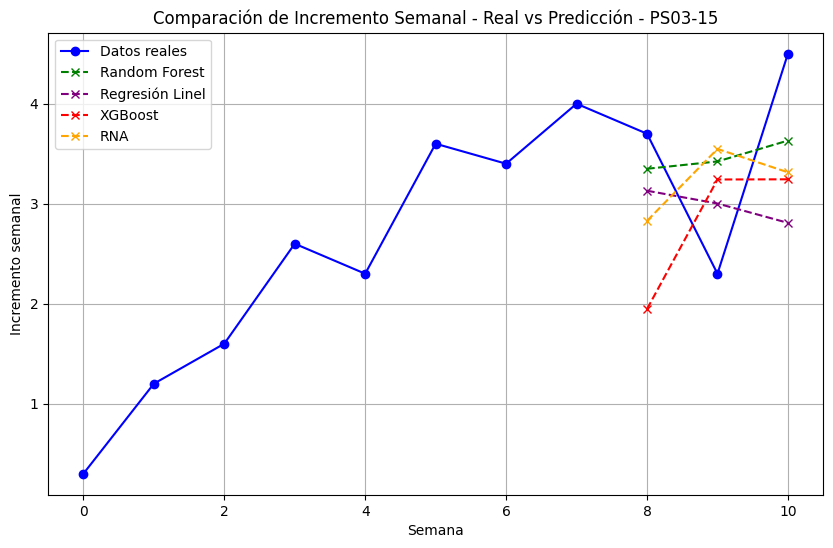

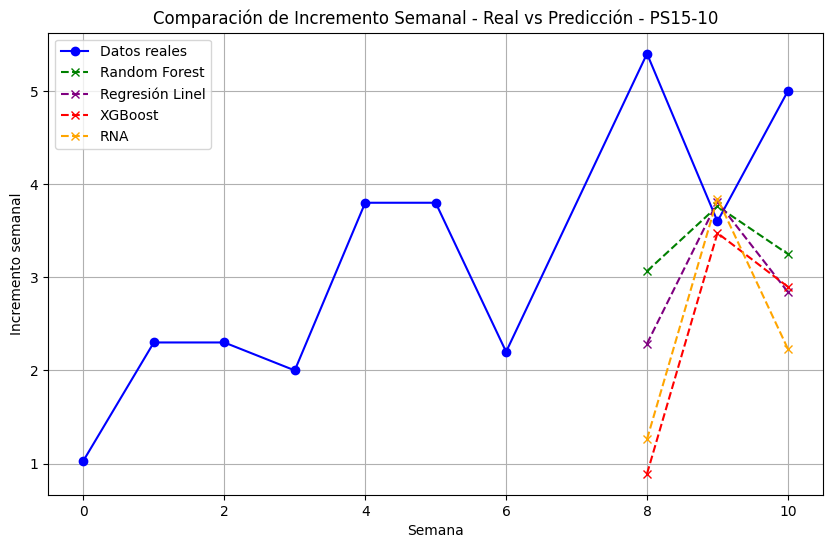

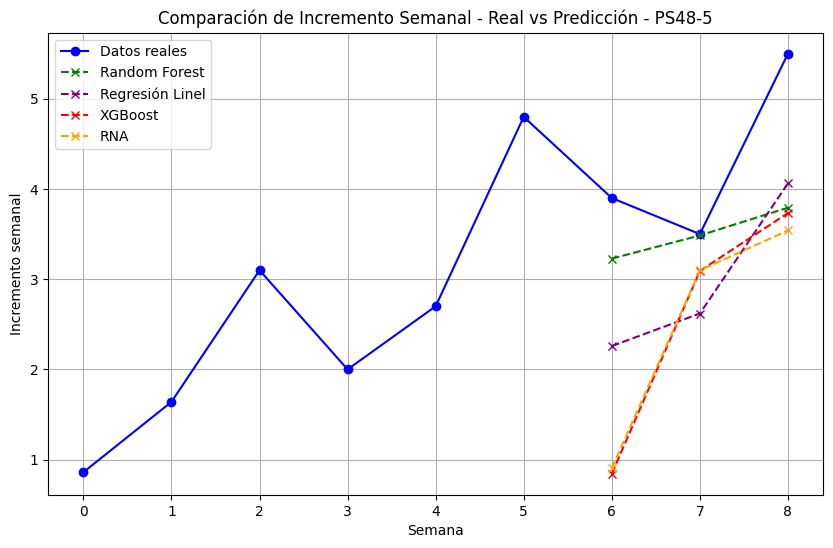

In [34]:
df_nuevo_real =pd.read_excel("Datos nuevos.xlsx")
prediccion_peso(["PS03-15", "PS15-10", "PS48-5"], df_nuevo_real, rf_model, "Random Forest")
plt.show()